In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def spatial_histogram(src, m):
	height, width = src.shape
	# Take size of block;
	h_blocks = int(height / m)
	w_blocks = int(width / m)
	H = np.zeros((m, m))
	for i in range(m):
		for j in range(m):
			H[i, j] = np.sum(src[(i * h_blocks):((i + 1) * h_blocks - 1), (j * w_blocks):((j + 1) * w_blocks - 1)])
	return H

In [3]:
file_path = "dataset/video1.mp4"
cap = cv2.VideoCapture(file_path)

fps = cap.get(cv2.CAP_PROP_FPS)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# duration = int(frameCount / fps)
# print('fps = ' + str(fps))
# print('number of frames = ' + str(frameCount))
# print('duration (S) = ' + str(duration))


In [4]:
# Take the first frame and convert it to gray
ret, frame1 = cap.read()
gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Create the HSV color image
hsvImg = np.zeros_like(frame1)
# print(hsvImg.shape)
hsvImg[..., 1] = 255
data = []

In [5]:
while True:
	# Save the previous frame data
	previousGray = gray
	
	# Get the next frame
	ret, frame2 = cap.read()
	if ret:
		# Convert the frame to gray scale
		gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
		
		# Calculate the dense optical flow
		flow = cv2.calcOpticalFlowFarneback(previousGray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
		
		# Obtain the flow magnitude and direction angle
		magnitude, direction_angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
# 		magnitude = magnitude / np.max(magnitude)
		H = spatial_histogram(magnitude, 10)
		H = H.ravel()
		data.append(H)
	# Update the color image
	# hsvImg[..., 0] = 0.5 * direction_angle * 180 / np.pi
	# hsvImg[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
	# rgbImg = cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)
	
	# Display the resulting frame
	# imS = cv2.resize(np.hstack((frame2, rgbImg)), (960, 540))
	# plt.imshow(H)
	# plt.imshow(imS)
	# plt.show()
	
	# Exit if the user press ESC
	if cv2.waitKey(1) and ret == False:
		break

# When everything is done, release the capture and close all windows
cap.release()
cv2.destroyAllWindows()

In [6]:
# import scipy.io
# scipy.io.savemat('magnitude_matrix.mat', mdict={'magnitude_matrix': magnitude_matrix})
# scipy.io.savemat('direction_angle_matrix.mat', mdict={'direction_angle_matrix': direction_angle_matrix})

In [7]:
nan_check = np.isinf(data)
x, y = np.where(nan_check == True)

In [8]:
for item in data:
    for i in item:
        if np.isinf(i) == True:
            i = 0

In [9]:
K = 250
kmeans = KMeans(n_clusters=K, random_state=0).fit(data)
center = kmeans.cluster_centers_
np.savetxt('Kmeans_cluster_centers.txt', kmeans.cluster_centers_, delimiter=',')
center = np.float32(center)
predict_kmean = kmeans.predict(data)

In [10]:
import math
overlap_frame = 20
frame_per_segment = 80
start_frame = 0

N = math.ceil((frameCount - overlap_frame)/(frame_per_segment - overlap_frame))
C = np.zeros(shape=(N,K))
segment_part=[]

for j in range(0,N):
    stop_frame = start_frame + frame_per_segment - 1
    for i in range(start_frame, stop_frame):
        cap.read()
        x = int(predict_kmean[i])
        C[j,x] = 1
        if frameCount < stop_frame:
            stop_frame = frameCount-1
            break
    segment_part.append([start_frame,stop_frame])
    start_frame = stop_frame - overlap_frame
    cap.set(cv2.CAP_PROP_FRAME_COUNT,start_frame)
    cap.set(cv2.CAP_PROP_FRAME_COUNT,start_frame)

In [11]:
# Show prototype thu i
# k = np.reshape(center[339,:], (10,10))
# plt.imshow(k)
# plt.show()

In [12]:
# np.where(predict_kmean == 339)

In [13]:
#calculate pi-pj chi-square: S /not symetics
from scipy.stats import chisquare
S = np.zeros(shape=(K,K))
for i in range(K):
    for j in range(K):
#         S[i,j] = (cv2.compareHist(np.reshape(center[i],(10,10)), np.reshape(center[j],(10,10)),cv2.HISTCMP_CHISQR) + 
#                 cv2.compareHist(np.reshape(center[j],(10,10)), np.reshape(center[i],(10,10)),cv2.HISTCMP_CHISQR))/2
        S[i,j] = (chisquare(center[i],center[j])[0] + chisquare(center[j],center[i])[0])/2

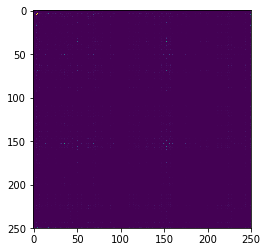

0.0
35853283328.0


In [14]:
#Calculate matrix W:
Snorm = np.uint8(S)
belta = 1/np.max(S)
# Snorm = np.float32(S)
W = np.eye(N, dtype = float)
C_T = C.transpose()
W = np.append(W,C,axis=1)
W = np.append(W,np.append(C_T,belta*S,axis=1),axis=0)

plt.imshow(S)
plt.show()
# print(np.max(W))
# print(np.min(W))
print(np.min(S))
print(np.max(S))

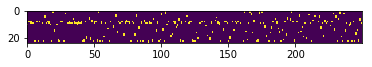

In [15]:
#plot C:
plt.imshow(C)
plt.show()

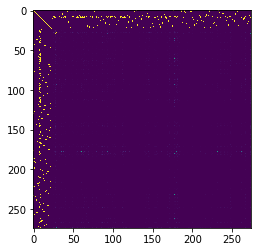

In [16]:
plt.imshow(W)
plt.show()
np.savetxt('W.txt', W, delimiter=',')

In [17]:
#Solve optimaize problem:
def diagonal_matrix(matrix):
    diagonal = np.zeros(shape=(N+K,N+K))
    row,col = matrix.shape
    for i in range(row):
        diagonal[i,i] = sum(matrix[:,i])
    
    return diagonal
D = diagonal_matrix(W)


In [18]:
lamda, eig_vector = np.linalg.eigh((D-W).dot(np.linalg.inv(D)))

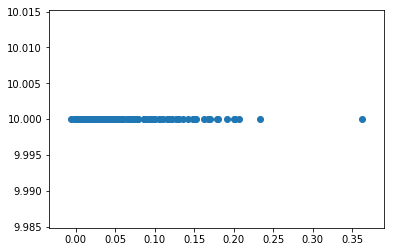

In [19]:
x = eig_vector[:,1]
plt.scatter(x,np.zeros(K+N)+10)
plt.show()

In [29]:
kmean2 = KMeans(n_clusters=2, random_state=0).fit(x.reshape(-1,1))
center2 = kmean2.cluster_centers_
center2

array([[0.01417255],
       [0.13820437]])

In [30]:
# Inter-cluster distance matrix
from sklearn.metrics.pairwise import euclidean_distances
dists = euclidean_distances(kmean2.cluster_centers_)
total = np.sum(dists,axis=0) #total of inter-cluster distance
abnormal_cluster = np.argmax(total)
# abnormal_cluster = 0

In [31]:
#Show the predict abnormal frame
labels_segment = kmean2.predict(x.reshape(-1,1))[:N]
idx = [i for i, j in enumerate(labels_segment) if j == abnormal_cluster]
segment_abnormal = []
for i in idx:
    segment_abnormal.append(segment_part[i])

predict = np.zeros(shape=frameCount)
for i in range(frameCount):
    for j in range(len(idx)):
        if segment_abnormal[j][0] <= i and i <= segment_abnormal[j][1]:
            predict[i] = 1
frame_abnormal = np.asarray([i for i, j in enumerate(predict) if j == 1])

In [32]:
predict

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
#Show the grouth truth
box_ground = [[500,600],[1305,1432]]
ground_truth = np.zeros(shape=frameCount)
for i in range(frameCount):
#     if (325<=i and i<=473) :
    if (500<=i and i<=600) or (1305<=i and i<=1432):
        ground_truth[i] = 1

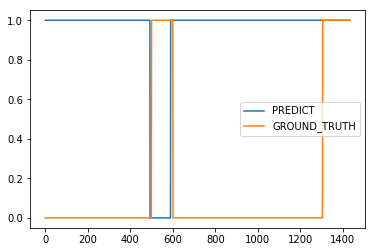

In [34]:
#show the result frame
num_frame = [i for i in range(frameCount)]

fig, ax = plt.subplots()
ax.plot(num_frame, predict, label="PREDICT")
ax.plot(num_frame, ground_truth, label="GROUND_TRUTH")
ax.legend()

plt.show()

In [26]:
# cap = cv2.VideoCapture(file_path)
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))
# out = cv2.VideoWriter('abnormal_video.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
# i = 0
# while(True):
#     ret, frame = cap.read()
    
#     if ret == True: 
#         if predict[i] == 1:
#             # Write the frame into the file 'output.avi'
#             out.write(frame)
#         # Display the resulting frame    
#         cv2.imshow('frame',frame)
        
#     i = i+1
 
#     # Press Q on keyboard to stop recording
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#     # Break the loop
#     else:
#         break 

# #When everything done, release the video capture and video write objects
# cap.release()
# out.release()
 
# # Closes all the frames
# cv2.destroyAllWindows() 

In [27]:
# import pandas as pd
# def get_iou_vector(A, B, n):
#     intersection = np.logical_and(A, B)
#     union = np.logical_or(A, B)
#     iou = np.sum(intersection > 0) / np.sum(union > 0)
#     print(iou)
#     s = pd.Series(name=n)
#     for thresh in np.arange(0.5,1,0.05):
#         s[thresh] = iou > thresh
#     return s

# print('Does this IoU hit at each threshold?')
# print(get_iou_vector(predict, ground_truth, 'GT-P'))

In [28]:
box_predict = []
j = 0
left = frame_abnormal[j]
while True:
    if frame_abnormal[j+1] - frame_abnormal[j] != 1:
        right = frame_abnormal[j]
        box_predict.append([left,right])
        left = frame_abnormal[j+1]
    j = j + 1
    if j == (len(frame_abnormal) - 1):
        right = frame_abnormal[j]
        box_predict.append([left,right])
        break

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
def box_iou(pred,ground,num_pred,num_ground):

    pred_left = pred[num_pred][0]
    pred_right = pred[num_pred][1]
    ground_left = ground[num_ground][0]
    ground_right = ground[num_ground][1]
    
    edge_left = np.min([pred_left,pred_right,ground_left,ground_right]) #0
    edge_right = np.max([pred_left,pred_right,ground_left,ground_right]) #600
    
    pred_list = np.zeros(shape=frameCount)
    ground_list = np.zeros(shape=frameCount)
    
    for y in range(len(pred_list)):
        if pred_left <= y and y <= pred_right:
            pred_list[y] = 1 # 0->475: 1
        elif ground_left <= y and y <= ground_right:
            ground_list[y] = 1 #500 -> 600 : 1
    
    intersection = np.logical_and(pred_list,ground_list).sum() #25
    union = edge_right - edge_left + 1 - intersection
    iou = intersection/union
    
    return iou

In [ ]:
iou_pred = []
for i in range(len(box_predict)):
    iou_all = []
    for j in range(len(box_ground)):
        iou_all.append(box_iou(box_predict,box_ground,i,j))
    iou_pred.append(np.max(iou_all))

In [ ]:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('result.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if predict[i] == 1:
            cv2.putText(frame,'Abnormal activity',(10,220),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_8, False)
        out.write(frame)
        cv2.imshow('Frame',frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        i = i + 1
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
frameCount = 361
a = np.zeros(shape=frameCount)
b = np.zeros(shape=frameCount)
for i in range(frameCount):
#     if (325<=i and i<=473) :
    if (500<=i and i<=600) or (1305<=i and i<=1432):
        a[i] = 1
        
for i in range(frameCount):
#     if (325<=i and i<=473) :
    if (45<=i and i<=132):
        b[i] = 1

#show the result frame
num_frame = [i for i in range(frameCount)]

fig, ax = plt.subplots()
ax.plot(num_frame, a, label="PREDICT")
ax.plot(num_frame, b, label="GROUND_TRUTH")
ax.legend()

plt.show()